# Colour Correction using Splines

### Define constants

In [ ]:
%load_ext autoreload
%autoreload 2
import colour
from data import load_dataset_sfu, load_dataset_csv, load_cmfs, load_camera, load_insitu, msds_to_rgb, msds_to_xyz, load_dataset_skin
import numpy as np

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)
    
SFU_FILE_PATH = 'reflect_db.reflect'
CAVE_FOSTER2004_PATH = 'cave_foster2002.csv'
INSITU_PATH = "insitu_dataset.csv"
CAVE_PATH = 'cave.csv'
FOSTER_50_PATH = 'foster50.csv'
CAMERA = 'nikon'

In [ ]:

sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
cave_foster2004_dataset = load_dataset_csv(CAVE_FOSTER2004_PATH)
foster_50_dataset = load_dataset_csv(FOSTER_50_PATH)
insitu = load_insitu(INSITU_PATH)
cave = load_dataset_csv(CAVE_PATH)
skin = load_dataset_skin()


In [92]:
MSDS_TRAIN = load_camera(CAMERA)

In [90]:
from plotting import plot_chromaticity_diagram
TRAIN = cave
TEST = foster_50_dataset
VALIDATION = sfu_dataset

### Computing Observer Responses
We can easily change the order of test and train sets here

In [95]:
from plotting import plot_chromaticity_diagram

cmfs, illuminant = load_cmfs()
response_trainset_xyz = msds_to_xyz(TRAIN, cmfs, illuminant)
response_testset_xyz = msds_to_xyz(TEST, cmfs, illuminant)
response_validation_xyz = msds_to_xyz(VALIDATION, cmfs, illuminant)

[ 0.94940092  1.          1.08709122]
[ 0.94940092  1.          1.08709122]
[ 0.94940092  1.          1.08709122]


### Computing Camera Responses

In [96]:
response_trainset_camera = msds_to_rgb(TRAIN,MSDS_TRAIN, illuminant)
response_testset_camera = msds_to_rgb(TEST,MSDS_TRAIN, illuminant)
response_validationset_camera = msds_to_rgb(VALIDATION,MSDS_TRAIN, illuminant)

### Fit Generalized Additive Model with P-splines

### Nikon

In [97]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
np.int = np.int64
if CAMERA == 'nikon':
    # gam = GAMOptimizer(lams=1e-6, order=3, n_splines=5)
    
    # gam = GAMOptimizer(lams=0.0001,order=3, n_splines=10)
    gam = GAMOptimizer(lams=0.01,order=3, n_splines=20)

    gam.fit(response_trainset_camera, response_trainset_xyz)

    pred(gam, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

3600
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.96
DeltaE max: 5.71
DeltaE median: 0.82
DeltaE 95 percentile: 2.13
DeltaE 99 percentile: 2.67


### Sigma

In [77]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
np.int = np.int64
if CAMERA == 'sigma':
    # gam = GAMOptimizer(lams=1e-9, order=3, n_splines=5)
    # gam = GAMOptimizer(lams=0.0001,order=3, n_splines=10)
    gam = GAMOptimizer(lams=0.0001,order=3, n_splines=20)

    gam.fit(response_trainset_camera, response_trainset_xyz)

    pred(gam, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

### Fit Linear Model

In [78]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression(fit_intercept=False)


linear.fit(response_trainset_camera, response_trainset_xyz)
pred(linear, response_testset_camera, response_testset_xyz, "Foster 50")


---- RESULTS Foster 50 ----
DeltaE mean: 1.07
DeltaE max: 6.56
DeltaE median: 0.93
DeltaE 95 percentile: 2.41
DeltaE 99 percentile: 3.26


### Fit 3rd order Root-Polynomial Model

In [79]:
from models import PolynomialTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=True)),
    ('regressor', LinearRegression(fit_intercept=False))
])

RP_linear_3.fit(response_trainset_camera, response_trainset_xyz)

pred(RP_linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.01
DeltaE max: 5.56
DeltaE median: 0.80
DeltaE 95 percentile: 2.39
DeltaE 99 percentile: 3.04


### Fit a 2nd order Root-Polynomial Model

In [80]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_2 = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=True)),
    ('regressor', LinearRegression(fit_intercept=False))
])


RP_linear_2.fit(response_trainset_camera, response_trainset_xyz)
pred(RP_linear_2, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.02
DeltaE max: 6.07
DeltaE median: 0.82
DeltaE 95 percentile: 2.42
DeltaE 99 percentile: 3.12


In [81]:
P_Linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=False)),
    ('regressor', LinearRegression(fit_intercept=False))
])


P_Linear_3.fit(response_trainset_camera, response_trainset_xyz)
pred(P_Linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.93
DeltaE max: 5.96
DeltaE median: 0.79
DeltaE 95 percentile: 2.24
DeltaE 99 percentile: 3.24


In [82]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=False)),
    ('regressor', LinearRegression(fit_intercept=False))
])


P_linear.fit(response_trainset_camera, response_trainset_xyz)
pred(P_linear, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.90
DeltaE max: 5.21
DeltaE median: 0.78
DeltaE 95 percentile: 2.13
DeltaE 99 percentile: 3.06


In [83]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000P = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=3))
])


DE2000P.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000P, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.62210388683
        x: [ 7.247e-01  2.062e-01 ..., -6.356e-01  2.752e+00]
      nit: 255
      jac: [ 4.597e-06  3.628e-06 ...,  3.353e-07  3.651e-07]
 hess_inv: [[ 2.063e-01 -2.459e-01 ...,  1.109e+00 -2.171e+00]
            [-2.459e-01  5.412e-01 ..., -1.975e+00  4.922e+00]
            ..., 
            [ 1.109e+00 -1.975e+00 ...,  2.002e+02 -4.856e+02]
            [-2.171e+00  4.922e+00 ..., -4.856e+02  1.924e+03]]
     nfev: 15602
     njev: 269
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.90
DeltaE max: 5.26
DeltaE median: 0.76
DeltaE 95 percentile: 2.15
DeltaE 99 percentile: 3.08


In [84]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=True, degree=3))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.612530750384
        x: [ 2.947e-01  3.561e+00 ...,  1.793e+00  3.046e+00]
      nit: 483
      jac: [ 7.493e-04 -9.331e-05 ...,  1.675e-04  1.427e-04]
 hess_inv: [[ 6.121e+00  9.132e+00 ..., -8.637e+00 -3.917e+00]
            [ 9.132e+00  9.101e+01 ...,  1.009e+02  7.965e+01]
            ..., 
            [-8.637e+00  1.009e+02 ...,  2.110e+03  4.582e+02]
            [-3.917e+00  7.966e+01 ...,  4.582e+02  1.752e+03]]
     nfev: 24332
     njev: 608
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.89
DeltaE max: 5.50
DeltaE median: 0.73
DeltaE 95 percentile: 2.17
DeltaE 99 percentile: 2.96


In [85]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=1))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.895430116258
        x: [ 6.913e-01  2.195e-01  3.531e-02  2.715e-01  1.007e+00
            -2.805e-01  6.242e-02 -2.989e-01  1.317e+00]
      nit: 32
      jac: [-3.308e-06  7.670e-05  1.499e-04  2.435e-04  1.626e-04
             1.067e-04 -1.137e-04 -1.025e-04 -9.914e-05]
 hess_inv: [[ 2.559e-02 -4.039e-02 ..., -3.905e-02  1.791e-02]
            [-4.039e-02  8.886e-02 ...,  8.826e-02 -4.903e-02]
            ..., 
            [-3.905e-02  8.826e-02 ...,  1.543e-01 -8.955e-02]
            [ 1.791e-02 -4.903e-02 ..., -8.955e-02  6.556e-02]]
     nfev: 741
     njev: 73
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.95
DeltaE max: 5.45
DeltaE median: 0.83
DeltaE 95 percentile: 2.14
DeltaE 99 percentile: 2.98


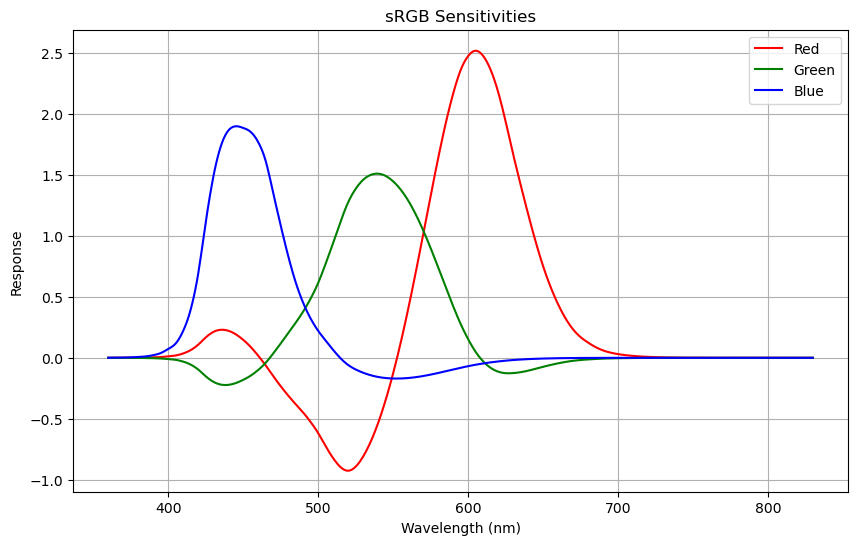

In [86]:
import colour
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the XYZ colour matching functions.
cmfs = colour.colorimetry.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

# Wavelengths of the standard observer.
wavelengths = cmfs.wavelengths

# Converting XYZ to sRGB sensitivities
# sRGB colour matching functions are derived from the XYZ ones by applying the sRGB colour space matrix.
rgb_colourspace = colour.RGB_COLOURSPACES['sRGB']
matrix_XYZ_to_RGB = rgb_colourspace.matrix_XYZ_to_RGB

# Applying the matrix to each XYZ sensitivity
sRGB_sensitivities = np.dot(cmfs.values, matrix_XYZ_to_RGB.T)

# Plotting the sensitivities
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, sRGB_sensitivities[:, 0], label='Red', color='r')
plt.plot(wavelengths, sRGB_sensitivities[:, 1], label='Green', color='g')
plt.plot(wavelengths, sRGB_sensitivities[:, 2], label='Blue', color='b')
plt.title('sRGB Sensitivities')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)


In [87]:
from models import GAMOptimizer
from evaluate import pred
from sklearn.pipeline import Pipeline
from models import PolynomialTransformer
from sklearn.linear_model import LinearRegression
from colour import SpectralShape
from colour import MSDS_CAMERA_SENSITIVITIES, MSDS_CMFS
import numpy as np
#spectra = Pipeline([
#    ('transformer', PolynomialTransformer(degree=3, rp=False)),
#    ('regressor', LinearRegression(fit_intercept=False))
# ])

spectra = GAMOptimizer(lams=1e-3, order=3, n_splines=20)


cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].copy()
MSDS_TRAIN = MSDS_CAMERA_SENSITIVITIES['Nikon 5100 (NPL)']
cmfs.values = cmfs.values / np.max(cmfs.values)
source = MSDS_TRAIN.align(SpectralShape(400, 700, 1)).values
target = cmfs.align(SpectralShape(400, 700, 1)).values
print(MSDS_TRAIN.wavelengths)
spectra.fit(source, target)

[ 400.  401.  402.  403.  404.  405.  406.  407.  408.  409.  410.  411.
  412.  413.  414.  415.  416.  417.  418.  419.  420.  421.  422.  423.
  424.  425.  426.  427.  428.  429.  430.  431.  432.  433.  434.  435.
  436.  437.  438.  439.  440.  441.  442.  443.  444.  445.  446.  447.
  448.  449.  450.  451.  452.  453.  454.  455.  456.  457.  458.  459.
  460.  461.  462.  463.  464.  465.  466.  467.  468.  469.  470.  471.
  472.  473.  474.  475.  476.  477.  478.  479.  480.  481.  482.  483.
  484.  485.  486.  487.  488.  489.  490.  491.  492.  493.  494.  495.
  496.  497.  498.  499.  500.  501.  502.  503.  504.  505.  506.  507.
  508.  509.  510.  511.  512.  513.  514.  515.  516.  517.  518.  519.
  520.  521.  522.  523.  524.  525.  526.  527.  528.  529.  530.  531.
  532.  533.  534.  535.  536.  537.  538.  539.  540.  541.  542.  543.
  544.  545.  546.  547.  548.  549.  550.  551.  552.  553.  554.  555.
  556.  557.  558.  559.  560.  561.  562.  563.  5

GAMOptimizer(lams=0.001, n_splines=20, order=3)

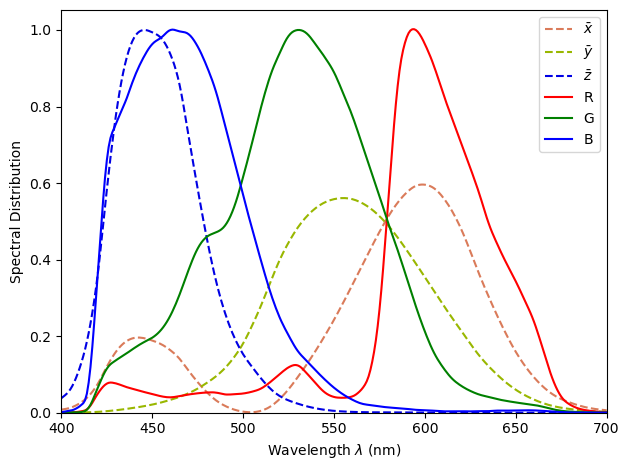

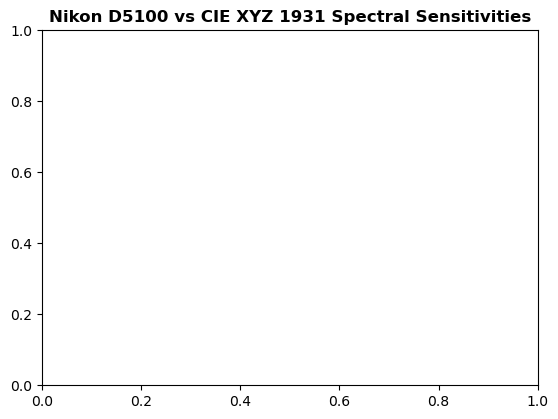

In [88]:
from colour.plotting import plot_multi_sds
from colour import MultiSpectralDistributions
import matplotlib.pyplot as plt
out = spectra.predict(MSDS_TRAIN.values)
out[out<0] = 0
out_spectra = MultiSpectralDistributions(out, SpectralShape(400, 700, 1))
plot_kwargs = [
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},

    {"use_sd_colours": False, "linestyle": "solid", "color": "red", "label": "R"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "green", "label": "G"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "blue", "label": "B"},
]
fig, ax = plot_multi_sds([cmfs, MSDS_TRAIN], plot_kwargs=plot_kwargs, transparent_background=False)
plt.subplots_adjust(top=0.85)

plt.title("Nikon D5100 vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")
plt.savefig("spectralsensitivities.png", transparent=False)

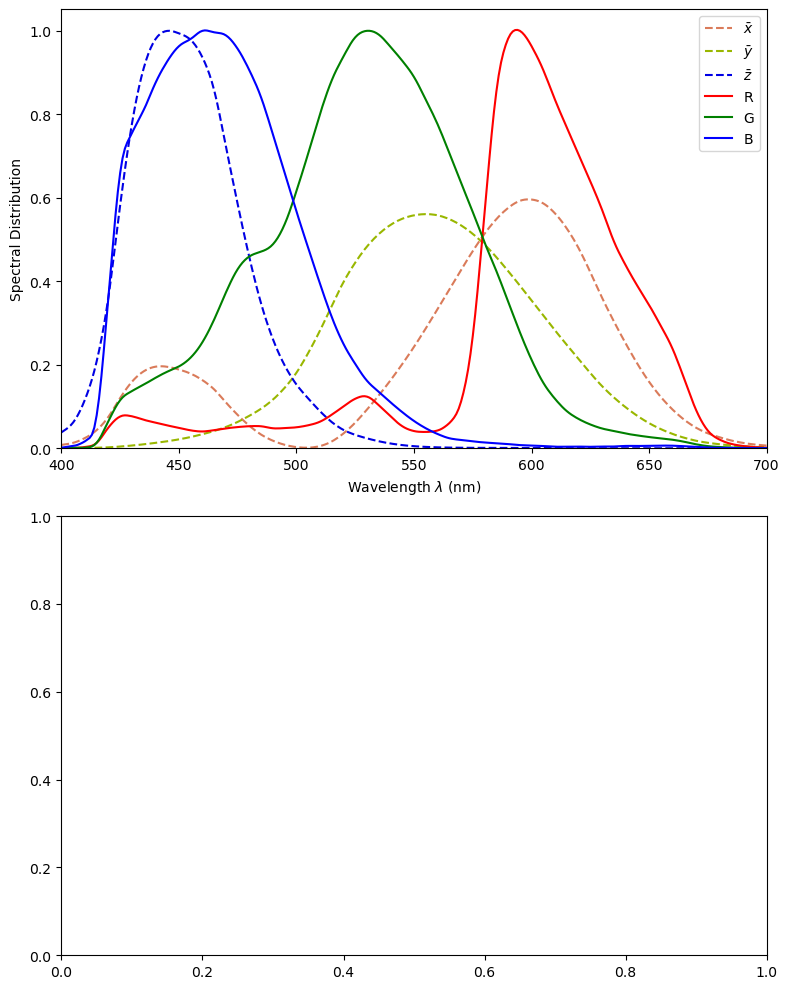

ValueError: too many values to unpack (expected 2)

In [89]:
# Your original plotting code here, modified to include subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # Creates 2 rows and 1 column of subplots

# Plot the first set of data on the first subplot
plot_multi_sds([cmfs, MSDS_TRAIN], plot_kwargs=plot_kwargs, transparent_background=False, axes=axs[0])
axs[0].set_title("Nikon D5100 vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")


MSDS_TEST, SDS_TEST = load_camera('sigma')
# Plot the second set of data on the second subplot
plot_multi_sds([cmfs, MSDS_TEST], plot_kwargs=plot_kwargs, transparent_background=False, axes=axs[1])
axs[1].set_title("Sigma SDMerill vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")

# Adjust the layout so that titles and labels don't overlap
plt.tight_layout()

# Save the figure
plt.savefig("spectralsensitivities_subplot.png", transparent=False)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cave_foster2004_dataset.values.T)
print(np.sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)